# Attribute Selection: Rotten Tomatoes Dataset

In [554]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import scipy as ap
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import seaborn as sns

## 1. Load data, and separate test data

In [588]:
#Loading the data
path = os.getcwd()
dataPath = path + "/data/rotten-tomatoes.csv.bz2"
data= pd.read_csv(dataPath)
#splitting into train and test parts
original_train, test = train_test_split(data, test_size=0.2)

#saving the test data to a csv file

#index is false, because we don't want the index of 
#the data frame to be a separate column in the output

test.to_csv(path+"/test.csv", index=False) 

#deleting the test data-frame from the memory
del test

## 2. Explore, clean and transform the data

In [589]:
#Seeing the first few lines of the data
original_train.head()

,critic,fresh,imdb,link,publication,quote,review_date,rtid,title
4867,Variety Staff,fresh,50083,http://www.variety.com/review/VE1117795934.htm...,Variety,The film leaves a tremendous impact.,2008-06-30 00:00:00,18108,12 Angry Men (Twelve Angry Men)
8463,Dave Kehr,fresh,53285,http://onfilm.chicagoreader.com/movies/capsule...,Chicago Reader,The masterpiece of the Disney Studios' postwar...,2008-09-03 00:00:00,21442,Sleeping Beauty
4216,Todd McCarthy,fresh,116404,http://www.variety.com/review/VE1117905658.htm...,Variety,A vital regeneration of a filmmaker's talent a...,2008-09-24 00:00:00,14585,Get on the Bus
6560,Desson Thomson,rotten,118884,http://www.washingtonpost.com/wp-srv/style/lon...,Washington Post,While the movie doesn't qualify as an awful wa...,2000-01-01 00:00:00,10172,Contact
10852,Janet Maslin,fresh,125439,http://movies.nytimes.com/movie/review?res=9D0...,New York Times,The movie has lots of glossy charm!,2000-01-01 00:00:00,10110,Notting Hill


In [590]:
print("Data type of all the columns:\n\n",original_train.dtypes)

Data type of all the columns:

 critic         object
fresh          object
imdb            int64
link           object
publication    object
quote          object
review_date    object
rtid            int64
title          object
dtype: object


In [591]:
#a) number of missings for fresh and quote
print("Number of missings for variable fresh:", sum(original_train.fresh == "none"))
print("Number of missings for variable quote:", sum(original_train.quote == "none"))

#b) all different values for fresh/rotten evaluations 
print("\nDifferent values for fresh/rotten evaluations:\n", original_train.fresh.value_counts())

#c) counts or percentages of these values
print("\nDifferent values for fresh/rotten evaluations in percentage:\n", 
      original_train.fresh.value_counts(normalize=True)*100)

#d) number of zero-length or only whitespace quote-s
print("\nNumber of zero-length quotes:", np.sum(original_train['quote'].str.len()==0))
print("\nNumber of only whitespace quotes:", np.sum(original_train['quote'].str.isspace()))

#e) minimum-maximum-average length of quotes (either in words, or in characters).
print("\nMaximum number of words in a quote:", np.max(original_train['quote'].str.split().str.len()))
print("Minimum number of words in a quote:", np.min(original_train['quote'].str.split().str.len()))
print("Mean number of words in a quote:", np.mean(original_train['quote'].str.split().str.len()))

#f) how many reviews are in data multiple times
print("\nNumber of duplicated reviews:", original_train.quote.duplicated().sum())


Number of missings for variable fresh: 22
Number of missings for variable quote: 0

Different values for fresh/rotten evaluations:
 fresh     6636
rotten    4095
none        22
Name: fresh, dtype: int64

Different values for fresh/rotten evaluations in percentage:
 fresh     61.713010
rotten    38.082396
none       0.204594
Name: fresh, dtype: float64

Number of zero-length quotes: 0

Number of only whitespace quotes: 0

Maximum number of words in a quote: 49
Minimum number of words in a quote: 1
Mean number of words in a quote: 20.131312191946435

Number of duplicated reviews: 377


In [592]:
#This function cleans the data by removing all the inconsistencies
#the table reveals ensuring that the central variables, quote and fresh, are not missing, and
#quote is not an empty string (or just contain spaces and such).

def cleanData(x):
    #replacing all the only white-space values in the quote column in the data with none
    x['quote'] = np.where(x['quote'].str.isspace()==True, 'none', x['quote'])

    #replacing all the "none" values in the training data with NaN
    x = x.replace("none",np.nan)

    x = x.dropna()
    
    
    #remove unnecessary variables critic, imdb, link, publication
    #review_date, rtid and title
    x = x.drop(labels = ["critic", "imdb", "link", "publication", "review_date", "rtid", "title"],
              axis = 1)
    
    #We also have to rename "fresh" columns as "fresh/rotten" because we will be using bag of words features later
    #and it may contain the actual word "fresh"

    x = x.rename(index=str, columns=({'fresh':'freshOrRotten'}))
    
    return x

In [593]:
#cleaning the train data
original_train = cleanData(original_train)

In [594]:
print("\nDifferent values for fresh/rotten evaluations in percentage:\n", 
      original_train.freshOrRotten.value_counts(normalize=True)*100)


Different values for fresh/rotten evaluations in percentage:
 fresh     61.790136
rotten    38.209864
Name: freshOrRotten, dtype: float64


* To extablish the baseline for Naive Bayes, we determine the percentages of number of "fresh" reviews and the number of "rotten" reviews. If we were to predict the reviews as fresh or rotten, we would not consider the effect of any other feature. Therefore, there is an almost 64% chance of a review being fresh irrespective of the affect of any other feature. This is the baseline accuracy of the model.

In [595]:
# getting all the quotes
train = original_train
a = train["quote"]

vec = CountVectorizer(binary=True)
x = vec.fit_transform(a)

#Constructing a new data frame where each row corresponds to each review, and the features
#are all the words on the bag of words
bowDF = pd.DataFrame(x.toarray())
bowDF.columns = vec.get_feature_names()

#Concating the train data with this bag of words data frame
train = pd.concat([train["freshOrRotten"].reset_index(drop=True),bowDF], axis = 1)#,ignore_index=True)

In [596]:
print("Shape of our new training set containing the Bag of Words:",train.shape)

#Encoding the fresh column of the train data as 1 for fresh and 0 for rotten
train["freshOrRotten"] = np.where(train["freshOrRotten"]=="fresh",1,0)

Shape of our new training set containing the Bag of Words: (10178, 18315)


## 3. Linear Models

### 3.1 Linear Regression

In [597]:
#I am sampling the data because the entire training data is too much for my computer to handle
sampleTrain = train.sample(n=1000, random_state=1)
y = sampleTrain["freshOrRotten"]
X = sampleTrain.drop("freshOrRotten",axis=1)

In [598]:
def calculateAccuracyScore(yTrue, yPredicted):
    
    yPredicted = np.asarray(yPredicted)
    yTrue = np.asarray(yTrue)
    
    #Through the linear model we have calculated the probabilities
    #If the probability is >0.5 or 50%, then the review is predicted to be fresh (1)
    #else it is predicted to be rotten(0). The following line make this conversion
    yPredicted = np.where(yPredicted > 0.5, 1, 0)
    
    truePositives = 0
    falsePositives = 0
    trueNegatives = 0
    falseNegatives = 0
     
    # Caclculating the confusion matrix    
    for i in range(0, len(yTrue)):
        if (yPredicted[i] == 1):
            if (yPredicted[i] == yTrue[i]):
                truePositives += 1
            else:
                falsePositives += 1
        else:
            if (yPredicted[i] == yTrue[i]):
                trueNegatives += 1
            else:
                falseNegatives += 1
    
    # Caclculating the accuracy
    accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)    
    return accuracy

In [599]:
#Make a scorer from a performance metric or loss function.
score = make_scorer(calculateAccuracyScore, greater_is_better=True)

In [600]:
m = LinearRegression().fit(X, y)

In [601]:
#Calculating the cross-validation results
results = cross_validate(m,     #The object to use to fit the data. This must be from the scikit-learn library only.
                         X,     #Features in the dataset
                         y,     #Predictor variable; "freshOrRotten" variable in the dataset
                         scoring=score, #supplying your own accuracy function for scoring
                         cv=5, #for stratified n-fold
                         return_train_score=False) #Not including train scores

In [602]:
print("Accuracy of linear model for 5-fold cross-validation:",np.mean(results['test_score']))

Accuracy of linear model for 5-fold cross-validation: 0.664


* Thus, from above we find that the mean accuracy of this linear model to be about 63.3%. It is also important to note here that the accuracy will slightly improve if we use more number of rows in our train data while training our model. Currently, I have only taken about a 1000 rows to train the model due to limited computing power of my Macbook Air.

### 3.2 Logistic regression

In [603]:
#I am ssampling the data because the entire training data is too much for my computer to handle
mLog = LogisticRegression(C=np.inf, solver="lbfgs").fit(X, y)

In [604]:
resultsLog = cross_validate(mLog, #The object to use to fit the data. This must be from the scikit-learn library only.
                         X,     #Features in the dataset
                         y,     #Predictor variable; "freshOrRotten" variable in the dataset
                         scoring=score, #supplying your own accuracy function for scoring
                         cv=5, #for stratified n-fold
                         return_train_score=False) #Not including train scores

In [605]:
print("Accuracy of logistic model for 5-fold cross-validation:",np.mean(resultsLog['test_score']))

Accuracy of logistic model for 5-fold cross-validation: 0.671956798919973


### 3.3 Forward selection

In [606]:
#xFS = X
#yFS = y

In [662]:
xFS.head()

,000,0014,007,044,07,10,100,101,104,108,...,zone,zoning,zooming,zooms,zorro,zorros,zowie,zweibel,zwick,zzzzzzzzz
941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [686]:
def bestFeature(addedFeatures, remainingFeatures):
    
    #This function selects the best feature based on CV accuracy
    
    #Input
    #y: The target variable
    #added_features: The features already added to the model
    #remaining_features: The features from the dataset yet to be added to the model
    
    #Output:
    #The feature from the remaining list which on being added to the model gets a higher accuracy
    
    feature = [] #Empty list to store the feature name
    accuracy = [] #Empty list to store the accuracy
    
    for i in remainingFeatures:
        
        #Adding each feature from the remaining list
        f = xFS[addedFeatures + [i]]
        mLog = LogisticRegression(C=np.inf, verbose=False, solver="lbfgs").fit(f, yFS)
        
        #Perform k-fold validation to get the mean loss and r-squared
        resultsLog = cross_validate(mLog, #The object to use to fit the data.
                         f,           #Features in the dataset
                         yFS,           #Predictor variable; "freshOrRotten" variable in the dataset
                         scoring=score, #supplying your own accuracy function for scoring
                         cv=5,          #for stratified n-fold
                         return_train_score=False)
        
        #Store the results for each variable
        feature.append(i)
        accuracy.append(np.mean(resultsLog['test_score']))
    
    data = pd.DataFrame({'features': feature,
                        'accuracy':accuracy})


    #returning the best model
    bestModel = data.iloc[data["accuracy"].idxmax()]
    return bestModel[0], bestModel[1]

In [688]:
#import warnings
#warnings.filterwarnings("ignore")

features = list(X.columns)
addedFeatures = []
forwardFeatureList = []
accuracy = []
temp = ""

for i in range(0,len(xFS.columns)-1):
    
    #Get the best features
    bestFeatureFromFunction, bestAccuracy = bestFeature(addedFeatures, features)
    
    #Add the best feature to list
    addedFeatures.append(bestFeatureFromFunction)
    
    #Remove used from list of features
    features.remove(bestFeatureFromFunction)   
    
    f = xFS[addedFeatures]
    mLog = LogisticRegression(C=np.inf, verbose=False, solver="lbfgs").fit(f, yFS)
    
    resultsLog = cross_validate(mLog, #The object to use to fit the data.
                         f,           #Features in the dataset
                         yFS,           #Predictor variable; "freshOrRotten" variable in the dataset
                         scoring=score, #supplying your own accuracy function for scoring
                         cv=5,          #for stratified n-fold
                         return_train_score=False) #Not including train scores
    
    accuracy.append(np.mean(resultsLog['test_score']))
    forwardFeatureList.append(addedFeatures)
    
    if(len(addedFeatures)>500):
        break
    
forwardSelection = pd.DataFrame({'Features': forwardFeatureList,
                                 'Accuracy': accuracy})

print("Feature with maximum accuracy during forward selection:\n",
      forwardSelection.iloc[forwardSelection["Accuracy"].idxmax()])

KeyboardInterrupt: 

Theoretically, we should see a slight improvement in the accuracy than as compared to a simple logistic model. I have included a hard condition in the program such that if the nuber of features exceeds 500, the program will stop. This function kept running for about 6 hours on my computer when I had to interrupt the kernel manually. Forward selection is excruciatingly slow.

### 3.4 Ridge and Lasso

In [630]:
#Lambda values
lambdaValues = [round(1e-5 * 10**i,6) for i in range(11)]
#The two regularization types Ridge(l2) and Lasso(l1)
regularizationType = ["l1", "l2"]
lambdaValues

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

In [631]:
regularizationType

['l1', 'l2']

In [632]:

accuracy = []                #Empty list to store accuracy
lambdaValuesList=[]          #Empty list to store lambda values
regularizationTypeList=[]    #Empty list to store regularization types

#The following code caluclates the logistic regression, and it's CV accuracy
#for different penalty types (Ridge/Lasso) and parameter values (lambda).

for i in regularizationType:
    for j in lambdaValues:
        mLog = LogisticRegression(C=1/j, #C is Inverse of regularization strength. Thus, C = 1/lamda
                                  penalty=i).fit(X, y) #Penalty is the type of regularization
    
        resultsLog = cross_validate(mLog, #The object to use to fit the data.This must be from the sk library only.
                             X,           #Features in the dataset
                             y,           #Predictor variable; "freshOrRotten" variable in the dataset
                             scoring=score, #supplying your own accuracy function for scoring
                             cv=5,          #for stratified n-fold
                             return_train_score=False) #Not including train scores
        accuracy.append(np.mean(resultsLog['test_score']))
        lambdaValuesList.append(j)
        regularizationTypeList.append(i)

In [633]:
regularizationData = pd.DataFrame({'RegularizationType': regularizationTypeList,
                                   'Lambda': lambdaValuesList,
                                   'Accuracy':accuracy})
print("The accuracy for ridge/lasso regularizations over the various lambda:\n",
      regularizationData)

l1 = regularizationData[regularizationData["RegularizationType"]=='l1']
l1Best = l1.iloc[l1["Accuracy"].idxmax()]

l2 = regularizationData[regularizationData["RegularizationType"]=='l2'].reset_index(drop=True)
l2Best = l2.iloc[l2["Accuracy"].idxmax()]

print("\n\nBest accuracy for Lasso:\n",l1Best)
print("\n\nBest accuracy for Ridge:\n",l2Best)

The accuracy for ridge/lasso regularizations over the various lambda:
    RegularizationType        Lambda  Accuracy
0                  l1       0.00001  0.676052
1                  l1       0.00010  0.679982
2                  l1       0.00100  0.655012
3                  l1       0.01000  0.646982
4                  l1       0.10000  0.643992
5                  l1       1.00000  0.663007
6                  l1      10.00000  0.612001
7                  l1     100.00000  0.388999
8                  l1    1000.00000  0.388999
9                  l1   10000.00000  0.388999
10                 l1  100000.00000  0.388999
11                 l2       0.00001  0.668942
12                 l2       0.00010  0.674927
13                 l2       0.00100  0.671947
14                 l2       0.01000  0.671952
15                 l2       0.10000  0.672942
16                 l2       1.00000  0.676002
17                 l2      10.00000  0.658027
18                 l2     100.00000  0.615011
19       

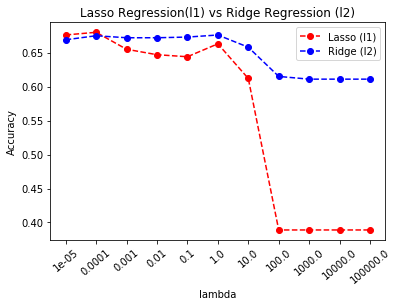

In [638]:
#Plotting the accuracy against lambda for each type of penalty/regularization
# create an index for each tick position
xi = [i for i in range(0, len(lambdaValues))]

#Plotting for Lasso
plt.plot(xi, 
         regularizationData[regularizationData["RegularizationType"]=='l1'].Accuracy,
        marker='o', linestyle='--', color='r', label='Lasso (l1)')

#Plotting for Ridge
plt.plot(xi, 
         regularizationData[regularizationData["RegularizationType"]=='l2'].Accuracy,
        marker='o', linestyle='--', color='b', label='Ridge (l2)')

plt.xticks(xi, np.asarray(lambdaValues), rotation = 40)
plt.title('Lasso Regression(l1) vs Ridge Regression (l2)')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.show()

From above it is clear that the the accuracy of the Ridge regularization is better than that of the Lasso regularization in general. It is also interesting to note the sudden drop in accuracy for Lasso regularization for higher lambda values (>100).

## 4. Naive Bayes

In [639]:
def calculateAccuracyScore2(yTrue, yPredicted):
    
    yPredicted = np.asarray(yPredicted)
    yTrue = np.asarray(yTrue)
    
    # This function is an exact replica of the calculateAccuracyScore function defined above except of the line:
    # yPredicted = np.where(yPredicted > 0.5, 1, 0). This line throws an error when used for non-linear models
    
    truePositives = 0
    falsePositives = 0
    trueNegatives = 0
    falseNegatives = 0
     
    # Caclculating the confusion matrix    
    for i in range(0, len(yTrue)):
        if (yPredicted[i] == 1):
            if (yPredicted[i] == yTrue[i]):
                truePositives += 1
            else:
                falsePositives += 1
        else:
            if (yPredicted[i] == yTrue[i]):
                trueNegatives += 1
            else:
                falseNegatives += 1
    
    # Caclculating the accuracy
    accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)    
    return accuracy

In [640]:
#Make a scorer from a performance metric or loss function. Same as the score function defined above
score2 = make_scorer(calculateAccuracyScore2, greater_is_better=True)

In [641]:
#This function return the train data set based on the the value of df_min which considers the terms to be included 
#as features only if they are present more than a minimum threshold which is given by df_min (input) 
#in the CountVectorizer function

def trainMinFreq(n):
    newDataFrame = original_train
    a = newDataFrame["quote"]

    vec = CountVectorizer(min_df = n, #ignore terms that have a document frequency strictly lower than min_df.
                          binary=True)
    x = vec.fit_transform(a)

    #Constructing a new data frame where each row corresponds to each review, and the features
    #are all the words on the bag of words
    bowDF = pd.DataFrame(x.toarray())
    bowDF.columns = vec.get_feature_names()

    #Concating the train data with this bag of words data frame
    newDataFrame = pd.concat([newDataFrame["freshOrRotten"].reset_index(drop=True),bowDF], axis = 1)
    #print("\nN:",n)
    return (newDataFrame)

In [642]:
#This list contains the minimum number of times a word is present in the data
#This will be passed to the CountVectorizer function to build the corresponding training set
minFrequency = [1,5,10,15,20]

#The different values of alpha
alpha = [1,3,5,7,9]

minFrequencyList = [] #Empty list to store the minimum frequency hyperparameter
alphaList = []        #Empty list to store the alpha value hyperparameter
numOfTerms = []       #Empty list to store the total number of reatures in the model
accuracy = []         #Empty list to store the accuracy

for i in minFrequency:
    train = trainMinFreq(i)
    #I am sampling the data because the entire training data is too much for my computer to handle
    sampleTrain = train.sample(n=2000, random_state=1)
    y = sampleTrain["freshOrRotten"]
    X = sampleTrain.drop("freshOrRotten",axis=1)
    
    for j in alpha:              
        mNB = MultinomialNB(alpha=j).fit(X, y)

        #Calculating the cross-validation results
        results = cross_validate(mNB,   #The object to use to fit the data. This must be from the sk library only.
                                 X,     #Features in the dataset
                                 y,     #Predictor variable; "freshOrRotten" variable in the dataset
                                 scoring=score2, #supplying your own accuracy function for scoring
                                 cv=5, #for stratified n-fold
                                 return_train_score=False) #Not including train scores
        
        minFrequencyList.append(i)
        numOfTerms.append(len(X.columns))
        alphaList.append(j)
        accuracy.append(np.mean(results['test_score']))
        
        

In [643]:
#Collating the findings in a data-frame
nbData = pd.DataFrame({'df_min': minFrequencyList,
                       'numberOfTerms': numOfTerms,
                       'alpha':alphaList,
                       'accuracy':accuracy})

print("The accuracy of the Multinomial NB model over the various df_min and alpha is:\n",
      nbData)

#Getting the best model
bestModel = nbData.iloc[nbData["accuracy"].idxmax()]

print("\n\nBest multinomial NB model with the highest accuracy has the following hyperparameters:\n",bestModel)

The accuracy of the Multinomial NB model over the various df_min and alpha is:
     df_min  numberOfTerms  alpha  accuracy
0        1          18314      1    0.6725
1        1          18314      3    0.6240
2        1          18314      5    0.6135
3        1          18314      7    0.6080
4        1          18314      9    0.6080
5        5           4548      1    0.6840
6        5           4548      3    0.6705
7        5           4548      5    0.6425
8        5           4548      7    0.6280
9        5           4548      9    0.6150
10      10           2348      1    0.6860
11      10           2348      3    0.6830
12      10           2348      5    0.6625
13      10           2348      7    0.6440
14      10           2348      9    0.6320
15      15           1594      1    0.6885
16      15           1594      3    0.6880
17      15           1594      5    0.6800
18      15           1594      7    0.6585
19      15           1594      9    0.6430
20      20       

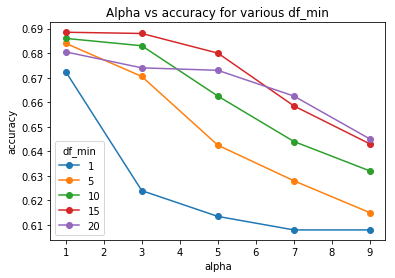

In [644]:
#Plotting the findings on a plot
fig, ax = plt.subplots()
 
for key, group in nbData.groupby('df_min'):
    group.plot('alpha','accuracy', marker='o', linestyle='-', label=key, ax=ax)

plt.ylabel("accuracy")
plt.title('Alpha vs accuracy for various df_min')
plt.legend(title="df_min")
plt.show()

Thus, from the above analyses it is clear that for the Naive Bayes Classification:
* Accuracy decreases with an increase in the alpha values
* Accuracy increases with an increase in the minimum number (df_min) of times a word is present in the data to be considered as a feature

## 5. Trees and forests

In [646]:
#this is preparing the data
train = original_train
a = train["quote"]

vec = CountVectorizer(binary=True)
x = vec.fit_transform(a)

#Constructing a new data frame where each row corresponds to each review, and the features
#are all the words on the bag of words
bowDF = pd.DataFrame(x.toarray())
bowDF.columns = vec.get_feature_names()

#Concating the train data with this bag of words data frame
train = pd.concat([train["freshOrRotten"].reset_index(drop=True),bowDF], axis = 1)

sampleTrain = train.sample(n=1000, random_state=1)
y = sampleTrain["freshOrRotten"]
X = sampleTrain.drop("freshOrRotten",axis=1)

def classifier(classifier = "Decision Trees"):
   
    #This function performs the operations for parts 5.1 and 5.2. The code for decision methods is 
    #essentially the same except for the classifier use. The hyperparameters are also the same.
    
    #This list contains the minimu impurity decrease
    impurity = [round(1e-5 * 10**i,6) for i in range(5)]

    #This list contains the various depths as stopping parameter
    depth = [2,4,6,8]

    impurityList = [] #Empty list to store the various minimum impurity values
    depthList = []    #Empty list to store the various maximum depth values
    accuracy = []     #Empty list to store the accuracy

    for i in impurity:
        for j in depth:
            if(classifier == "Decision Trees"): #For Decission Tree Classifier
                mDT = DecisionTreeClassifier(min_impurity_decrease=i, max_depth=j).fit(X, y)
            else: #For Random Forest Classifier
                mDT = RandomForestClassifier(min_impurity_decrease=i, max_depth=j).fit(X, y)

            #Calculating the cross-validation results
            resultDT = cross_validate(mDT,   #The object to use to fit the data. 
                                     X,     #Features in the dataset
                                     y,     #Predictor variable; "freshOrRotten" variable in the dataset
                                     scoring=score2, #supplying your own accuracy function for scoring
                                     cv=5, #for stratified n-fold
                                     return_train_score=False) #Not including train scores

            impurityList.append(i)
            depthList.append(j)
            accuracy.append(np.mean(resultDT['test_score']))
            
    
    #Collating the fidings in a data frame
    dtData = pd.DataFrame({'min_impurity_decrease': impurityList,
                       'max_depth': depthList,
                       'accuracy':accuracy})
    
    if(classifier == "Decision Trees"):
        s = "Decision Tree Classifier"
    else:
        s = "Random Forest Classifier"
    print("The accuracy of the",s," model over the various impurity and depth values is:\n",
          dtData)

    #printing the best model
    bestModel = dtData.iloc[dtData["accuracy"].idxmax()]

    print("\n\nBest",s," model with the highest accuracy has the following hyperparameters:\n",
          bestModel)
    
    #Plotting the findings on a plot
    fig, ax = plt.subplots()

    xi = [i for i in range(0, len(dtData.min_impurity_decrease.unique()))]

    for key, group in dtData.groupby('max_depth'):
        #xi = [i for i in range(0, len(group))]
        group = group.reset_index(drop=True)
        group = group.reset_index()
        group.plot("index","accuracy", marker='o', linestyle='-', label=key, xticks=group.index, ax=ax)

    plt.ylabel("accuracy")
    plt.xlabel("min_impurity_decrease")
    plt.xticks(xi, np.asarray(dtData.min_impurity_decrease.unique()))

    if(classifier == "Decision Trees"): #For Decission Tree Classifier
        t = 'min_impurity_decrease vs accuracy for various df_min for Decision Tree classifier'
    else: #For Random Forest Classifier
        t = 'min_impurity_decrease vs accuracy for various df_min for Random Forest classifier'

    plt.title(t)
    plt.legend(title="max_depth")
    plt.show()

### 5.1 Decision Trees

The accuracy of the Decision Tree Classifier  model over the various impurity and depth values is:
     min_impurity_decrease  max_depth  accuracy
0                 0.00001          2  0.617011
1                 0.00001          4  0.622001
2                 0.00001          6  0.624986
3                 0.00001          8  0.610996
4                 0.00010          2  0.616011
5                 0.00010          4  0.623006
6                 0.00010          6  0.623981
7                 0.00010          8  0.607976
8                 0.00100          2  0.616011
9                 0.00100          4  0.622001
10                0.00100          6  0.617971
11                0.00100          8  0.609981
12                0.01000          2  0.609001
13                0.01000          4  0.609001
14                0.01000          6  0.609001
15                0.01000          8  0.609001
16                0.10000          2  0.611001
17                0.10000          4  0.611001
18     

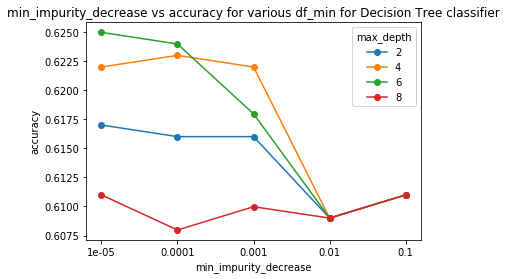

In [647]:
classifier("Decision Trees")

From above we can observe that for the decision tree classifier:
* Accuracy increasess with an increase in the value of min_impurity_decrease
* Accuracy decreases with increase in depth, although that might also lead to overfitting of the data.

### 5.2 Random Forest

The accuracy of the Random Forest Classifier  model over the various impurity and depth values is:
     min_impurity_decrease  max_depth  accuracy
0                 0.00001          2  0.611001
1                 0.00001          4  0.612001
2                 0.00001          6  0.613001
3                 0.00001          8  0.613006
4                 0.00010          2  0.610001
5                 0.00010          4  0.611001
6                 0.00010          6  0.615001
7                 0.00010          8  0.615021
8                 0.00100          2  0.611001
9                 0.00100          4  0.611996
10                0.00100          6  0.613996
11                0.00100          8  0.614021
12                0.01000          2  0.611001
13                0.01000          4  0.611001
14                0.01000          6  0.611001
15                0.01000          8  0.611001
16                0.10000          2  0.611001
17                0.10000          4  0.611001
18     

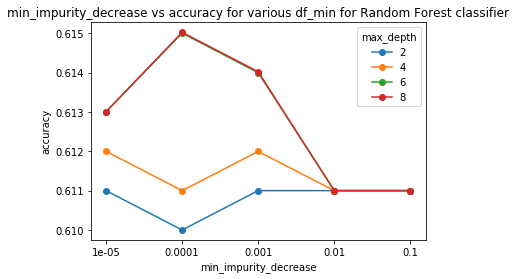

In [649]:
classifier("Random Forest")

From above we can observe that for the random forest classifier:
* Overall accuracy has increased as compared to the decision tree classifier
* Accuracy increasess with an increase in the value of min_impurity_decrease
* Accuracy decreases with increase in depth, although that might also lead to overfitting of the data.

min_impurity_decrease specifies A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

### 5.3 ADA Boost

In [650]:
#This list contains the minimu impurity decrease
nEstimators = [25,50,75,100,125]

#This list contains the various depths as stopping parameter
learningRate = [0.1,0.3,0.5,0.7,0.9]

learningRateList = [] #Empty list to store the various minimum impurity values
nEstimatorsList = []    #Empty list to store the various maximum depth values
accuracy = []     #Empty list to store the accuracy

for i in nEstimators:
    for j in learningRate:       
            mAB = AdaBoostClassifier(n_estimators=i, learning_rate=j).fit(X, y)

            #Calculating the cross-validation results
            resultAB = cross_validate(mAB,   #The object to use to fit the data. 
                                     X,     #Features in the dataset
                                     y,     #Predictor variable; "freshOrRotten" variable in the dataset
                                     scoring=score2, #supplying your own accuracy function for scoring
                                     cv=5, #for stratified n-fold
                                     return_train_score=False) #Not including train scores

            nEstimatorsList.append(i)
            learningRateList.append(j)
            accuracy.append(np.mean(resultAB['test_score']))

In [651]:
#Collating the fidings in a data frame
adaData = pd.DataFrame({'n_estimators': nEstimatorsList,
                       'learning_rate': learningRateList,
                       'accuracy':accuracy})

print("The accuracy of the ADA Boost classifier model over the various n_estimators and learning rate values is:\n",
      adaData)

#printing the best model
bestModel = adaData.iloc[adaData["accuracy"].idxmax()]

print("\n\nBest ADA Boost classifier model with the highest accuracy has the following hyperparameters:\n",
      bestModel)

The accuracy of the ADA Boost classifier model over the various n_estimators and learning rate values is:
     n_estimators  learning_rate  accuracy
0             25            0.1  0.618011
1             25            0.3  0.630006
2             25            0.5  0.622016
3             25            0.7  0.625996
4             25            0.9  0.625986
5             50            0.1  0.629016
6             50            0.3  0.642007
7             50            0.5  0.633042
8             50            0.7  0.645017
9             50            0.9  0.633971
10            75            0.1  0.635012
11            75            0.3  0.636002
12            75            0.5  0.641982
13            75            0.7  0.643997
14            75            0.9  0.628952
15           100            0.1  0.633012
16           100            0.3  0.637987
17           100            0.5  0.638972
18           100            0.7  0.642992
19           100            0.9  0.624952
20         

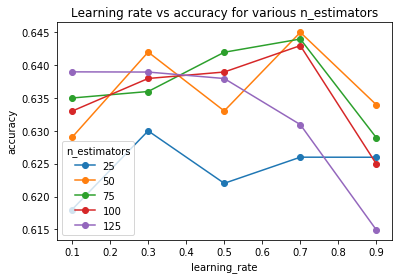

In [652]:
#Plotting the findings on a plot
fig, ax = plt.subplots()
 
for key, group in adaData.groupby('n_estimators'):
    group.plot('learning_rate','accuracy', marker='o', linestyle='-', label=key, ax=ax)

plt.ylabel("accuracy")
plt.title('Learning rate vs accuracy for various n_estimators')
plt.legend(title="n_estimators")
plt.show()

From above we see that for the ADA Boost classifier:
* Accuracy increases with an increase in the number of estimators
* Accuracy almost always first increases with the learning rate then it decreases
* There seems to be a tradeoff between the learning rate and the number of estimators
* This tradeoff seems intuitive because of the bias variance tradeoff. For the same number of iterations, a small learning rate is "under-fitting" (or the model has "high bias"), and a large learning rate is "over-fitting" (or the model has "high variance").



## 6. Final things

#### Reflect what did you do and what did you find. Which methods were good? Which ones were bad? Can you explain why?

I classified the reviews in the rotten tomatoes data set to determine if they are *fresh* or *rotten*. This was done by vectorizing each of the reviews and then one-hot encoding each word as a feature. This was rather a crude method to perform because we did not take into account other things that are important for text analysis such as removing stop words, stemming the words, lemmazitaion and formin n-grams. Through this exercise we trained our model to determine if the review was fresh or rotten depending upon the presence of each word in the review.

After a comprehensive analysis, I realize that most of the linear models are not perfect for this kind of classification. The worst performing linear model was the linear regression. Understandably so, because it predicted the probability of a review being fresh or rotten. Now, in linear regression, this probability was not an actual probability as it's range was not between 0 and 1. This was the most useless method for this type of a classification problem. Also, I found forward selection, in this particular case to be useless because of the ridiculous amount of time it took to run. Theoritically, I understand that it would improve the accuracy, but this method is computationally extensive. Another way in which we can reduce the number of features is the Principal Compoent Analysis (PCA). Regularization of a logistic model also had a recent run-time.

Logistic regression was still better as it had a better accuracy. This actually predicted the probabilities because of calculation of the logit. Subsequent improvements were seen when we performed the forward selection and the regularization on the logistic regression.

Naive Bayes was the best model (high accuracy) in this analysis. The ensemble methods, decision trees, random forests and ADA boost were pkay because they did not result in a greater accuracy than as compared to the linear models although I was expecting it to be the case. ADA boost took the longest time to run on my computer.

Lastly, it is important to note that the performance of all the above models is not perfect given the fact that the training data was particularly small (about 1000 observations) given the limited computing power of my laptop. I am certain we would definitely find better accuracy if more observations are taken into consideration when training the model.

#### Pick your favorite method. It is normally the one that gave you the best CV score, but in case that method caused other troubles (too slow, computer crashed, ...) you may opt for something else.

Naive Bayes classifier is my favorite model here because:
* It produced the highest test accuracy (about 70%)
* It running time was also low as compared to the other models. I was also able fit a larger sample size (~2000 observations) to the model.
* In particular, the NB model wherein alpha = 1 and df_min was 15, had the best prformance.

Thus I'll be considering this model.

#### Fit the model using the cross-validated optimal hyperparameters using your complete work data (both training and validation). This is your best and final model.

In [653]:
train = trainMinFreq(15)
sampleTrain = train.sample(n=2000, random_state=1)
y = sampleTrain["freshOrRotten"]
X = sampleTrain.drop("freshOrRotten",axis=1)
 
#Naive Bayes Classifier    
mNB = MultinomialNB(alpha=1).fit(X, y)

#Calculating the cross-validation results
results = cross_validate(mNB,   #The object to use to fit the data. This must be from the sk library only.
                         X,     #Features in the dataset
                         y,     #Predictor variable; "freshOrRotten" variable in the dataset
                         scoring=score2, #supplying your own accuracy function for scoring
                         cv=5, #for stratified n-fold
                         return_train_score=False) #Not including train scores

   
print("Train Accuracy of this Naive Bayes Classifier model",np.mean(results['test_score']))

Train Accuracy of this Naive Bayes Classifier model 0.6885000000000001


#### Load your testing data. Clean it using exactly the same procedure (you made a function for this, right?) and transform it into BOW-s.

In [654]:
#Loading the test data
test = pd.read_csv(path+"/test.csv")

#Cleaning the test data
test = cleanData(test)

In [655]:
a = test["quote"]

vec = CountVectorizer(min_df = 15, #This is 15 because in the train data we transformed the data keeping mi_df = 15
                      vocabulary = X.columns, #Keeping the same words as that in the train dataset
                      binary=True) #One-hot encoding of each word
x = vec.transform(a)

#Constructing a new data frame where each row corresponds to each review, and the features
#are all the words on the bag of words
bowDF = pd.DataFrame(x.toarray())
bowDF.columns = vec.get_feature_names()

#Concating the train data with this bag of words data frame
test = pd.concat([test["freshOrRotten"].reset_index(drop=True),bowDF], axis = 1)#,ignore_index=True)

In [656]:
#Retrieving the freshOrRotten column from the test data
yTrue = test["freshOrRotten"]

#Transforming the test data by dropping the target varaible
test = test.drop("freshOrRotten",axis=1)

In [657]:
#Calculating the predicted target variable from the NB classifier model trained above
yPredicted = mNB.predict(test)

In [658]:
#Printing the test accuracy
print("Accuracy on the test data when using the multinomial Naive Bayes Classifier"
      ,calculateAccuracyScore2(yTrue,yPredicted))

Accuracy on the test data when using the multinomial Naive Bayes Classifier 0.7106299212598425
